# <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Santader Customer Transaction Classification**</p>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg/640px-Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg"  width="1000" height="600">

## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Import Modules**</p>


In [45]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold,KFold
import warnings
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
from sklearn.decomposition import PCA
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import math
import plotly.express as px
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import eli5
from eli5.sklearn import PermutationImportance
import shap
from scipy import stats
from sklearn.metrics import roc_curve, auc
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import skew
from sklearn.model_selection import GridSearchCV


## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Loading The Data**</p>


In [46]:
#Load the Data
train = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
test = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Basic Analysis**</p>


In [47]:
train.shape, test.shape

((200000, 202), (200000, 201))

In [48]:
print('Column/Columns that are not in test data: ', end = '')
for i in train.columns:
    if i not in test.columns:
        print(i)

Column/Columns that are not in test data: target


> **Test data do not have target column.**

In [49]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


> **From initial analysis, I do not see max values to be way too out of bounds for some of the columns, so I don't think there are going to be many outliers. However, I would use an IQR to check for outliers as there are 200 columns and it would be difficult to investigate like this.** 

> **Also, I can see skewness exists in almost every variable. We are going to check further using displots.**

> **Dropping ID_code, won't be of any use.**

In [50]:
train.drop('ID_code', axis = 1, inplace = True)

In [51]:
train[train.duplicated()]

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199


**No duplicates exist**

## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Checking For The Null Values** </p>


In [52]:
train.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

> **All 0's exist. No null values.**

## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Checking For Class Imbalance**</p>


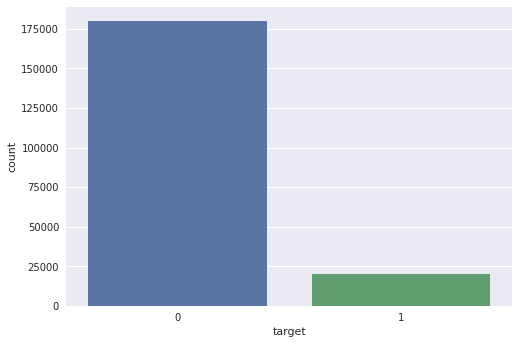

In [53]:

sns.countplot(train['target']);

## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Checking For Skewness**</p>


In [54]:
right_skewed, left_skewed, no_skeweness = 0, 0, 0

for col in list(set(train.columns) - set(['target'])):
    if skew(train[col])>0:
        right_skewed+=1        
    elif skew(train[col])==0:
        no_skeweness+=1
    else:
        left_skewed+=1

print("Features that are left skewed are: ", left_skewed)
print("Features that are left skewed are: ", right_skewed)
print("Features that are not skewed are: ", no_skeweness)

Features that are left skewed are:  88
Features that are left skewed are:  112
Features that are not skewed are:  0


#### <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Visualizing Right Skewness in Var_77 And How It Looks After Transformation**</p>


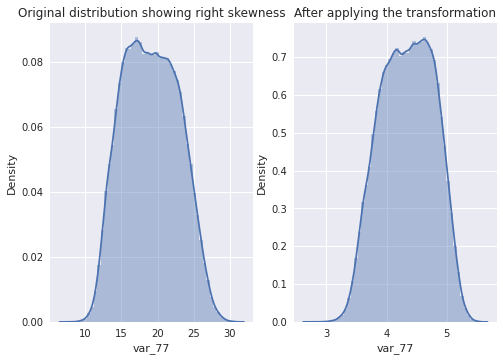

<Figure size 720x576 with 0 Axes>

In [55]:
fig, axes = plt.subplots(1, 2);
plt.figure(figsize = (10,8));
sns.distplot(train['var_77'], ax=axes[0]);
axes[0].set_title("Original distribution showing right skewness");
sns.distplot(np.sqrt(train['var_77']), ax=axes[1]);
axes[1].set_title('After applying the transformation');

#### <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Visualizing Left Skewness in Var_78 And How It Looks After Transformation**</p>


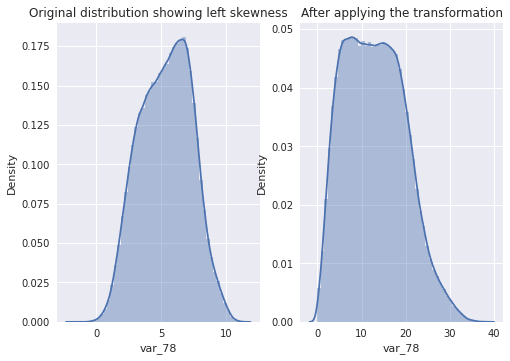

<Figure size 720x576 with 0 Axes>

In [56]:
 
fig, axes = plt.subplots(1, 2);
plt.figure(figsize = (10,8));
sns.distplot(train['var_78'], ax=axes[0]);
axes[0].set_title("Original distribution showing left skewness");
sns.distplot(np.power(train['var_78'], 1.5), ax=axes[1]);
axes[1].set_title('After applying the transformation');

#### <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Checking For Outliers**</p>


In [57]:
fig = px.box(train, y="var_0",
      title="Boxplot for var_0")
fig.update_layout(

    title_font_color="#fff",paper_bgcolor="#000000",title_font_size=20,title_x=.5,font_color="#bbb",
    plot_bgcolor="#D0D3D4")

fig.update_yaxes(showgrid=False,visible=False,title="percent of comments")
fig.update_xaxes(tickfont_size=9)
fig.show()

> **Outliers exists.**

> **Outliers have been removed now.**

> **Removed datapoints that fall outside  3 s.d**

In [58]:
train = train[(np.abs(stats.zscore(train)) < 3).all(axis=1)]
print("New shape after removing outliers:", train.shape)

New shape after removing outliers: (188969, 201)


In [59]:
X, y = train.drop('target', axis = 1), train ['target']

In [60]:
len(train[train['target'] == 0])/ len(train[train['target'] == 1])
    


9.037660682035483

### **Key points:**

> **There's a pretty good imbalance.**

> **For every sample of class 1, 9.03 samples of class 0 are present. We need to deal with class imbalance here.**

> **I would probably be using tomek links or SMOTE for dealing with it.**



## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Train Test Split** </p>


In [61]:
X_train, X_test, y_train, y_test = train_test_split( X,y 
                                                    , test_size = 0.20, random_state = 0) 
print("Shape of train data: ", X_train.shape)
print("Shape of test data: ", X_test.shape)

Shape of train data:  (151175, 200)
Shape of test data:  (37794, 200)


## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Creating a Baseline Model With LGBM**</p>


In [62]:

lgbm = LGBMClassifier(n_jobs=-1)

lgbm = lgbm.fit(X_train, y_train,eval_metric='auc',eval_set=(X_test , y_test),verbose=50,early_stopping_rounds= 50)



Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.845015	valid_0's binary_logloss: 0.257896
[100]	valid_0's auc: 0.869958	valid_0's binary_logloss: 0.236551
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.869958	valid_0's binary_logloss: 0.236551


In [63]:
print( 'Train roc auc score for LGBM: ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:, 1]))
print( 'Test roc auc score for LGBM: ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1]))

Train roc auc score for LGBM:  0.9264935495177117
Test roc auc score for LGBM:  0.8699576821929653


In [64]:
print(classification_report(y_test, lgbm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     34057
           1       0.89      0.09      0.17      3737

    accuracy                           0.91     37794
   macro avg       0.90      0.55      0.56     37794
weighted avg       0.91      0.91      0.87     37794



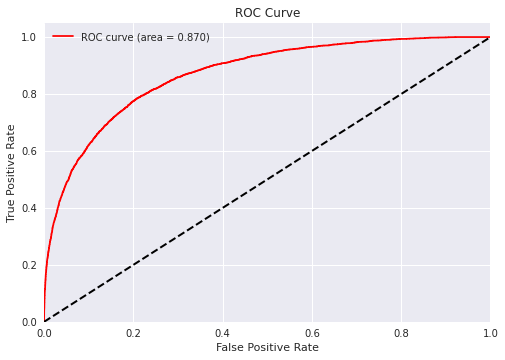

In [65]:
fpr, tpr, _ = roc_curve(y_test, lgbm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="upper left")
plt.show()


## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Interpreting Baseline Model Using Shap**</p>


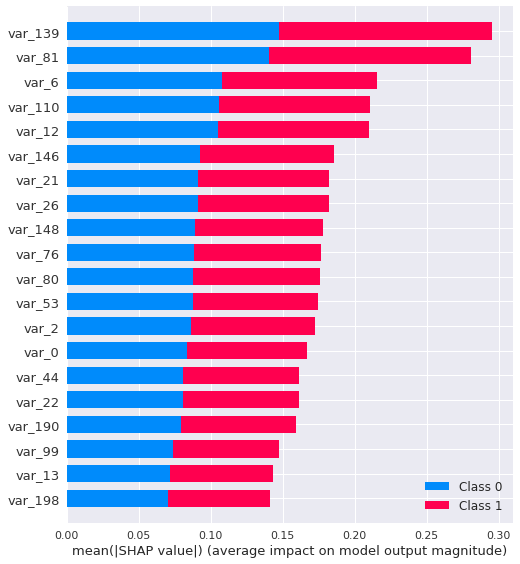

In [66]:
shap.initjs()

X_shap=X_train.copy()


lgb_explainer = shap.TreeExplainer(lgbm)
lgb_shap_values = lgb_explainer.shap_values(X_shap)
shap.summary_plot(lgb_shap_values, X_shap, plot_type="bar")

> **Here we can see which variable is pushing towards 0 and 1.**

## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Now that I have a baseline model, I'll try to improve it**</p>


## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Scaling the data**</p>


In [67]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Checking how much variance are different PCA components explaining**</p>


In [68]:
for components in range(100, 199):
    pca = PCA(n_components = components)
    pca.fit(X_train)
    print('Explained variance for ', components, 'is: ', sum(pca.explained_variance_ratio_))

Explained variance for  100 is:  0.5053097189468531
Explained variance for  101 is:  0.5102350039523194
Explained variance for  102 is:  0.5151666299373832
Explained variance for  103 is:  0.520510550213757
Explained variance for  104 is:  0.5252033473529489
Explained variance for  105 is:  0.5303300852092792
Explained variance for  106 is:  0.5351773123108797
Explained variance for  107 is:  0.5402068603574828
Explained variance for  108 is:  0.5451770455390592
Explained variance for  109 is:  0.5503994971315688
Explained variance for  110 is:  0.5549625344148593
Explained variance for  111 is:  0.5602160784309256
Explained variance for  112 is:  0.5651947565441023
Explained variance for  113 is:  0.5700501879904234
Explained variance for  114 is:  0.5751529670157749
Explained variance for  115 is:  0.5802662890795541
Explained variance for  116 is:  0.5851503252359619
Explained variance for  117 is:  0.5902860814079058
Explained variance for  118 is:  0.5951182684259769
Explained var

### **Key note**

> **For 160 components, explained variance goes as high as 81.86 which is pretty good. We have dropped down from 199 features.**

In [69]:
pca = PCA(n_components = 160)
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)

## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Balancing Data With Random Undersampling and Oversampling**</p>



In [70]:
print("Before doing any balancing, the distribution looks like","class 0: ",len(y[y==0]),"class 1: " ,len(y[y==1]))

Before doing any balancing, the distribution looks like class 0:  170143 class 1:  18826


In [71]:

over = RandomOverSampler(sampling_strategy=1)

print(Counter(y_train))

under = RandomUnderSampler(sampling_strategy=.15)
# fit and apply the transform
Xs, ys = under.fit_resample(X_train_PCA, y_train)
print(Counter(ys))

# fit and apply the transform
Xsmote, ysmote = over.fit_resample(Xs, ys)
print(Counter(ysmote))




Counter({0: 136086, 1: 15089})
Counter({0: 100593, 1: 15089})
Counter({0: 100593, 1: 100593})


> **This looks good. Class distribution is 1:1 now. Previously there was 1 : 9 ratio.**

## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Fitting LGBM With PCA Data**</p>



In [72]:

lgb_pca = LGBMClassifier(n_jobs=-1)

lgb_pca= lgb_pca.fit(Xsmote, ysmote,eval_metric='auc',eval_set=(X_test_PCA , y_test),verbose=50,early_stopping_rounds= 50)




Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.860508	valid_0's binary_logloss: 0.438716
[100]	valid_0's auc: 0.863141	valid_0's binary_logloss: 0.415977
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.863145	valid_0's binary_logloss: 0.416592


In [73]:
print( 'Train roc auc score for LGBM: ', roc_auc_score(ysmote, lgb_pca.predict_proba(Xsmote)[:, 1]))
print( 'Test roc auc score for LGBM: ', roc_auc_score(y_test, lgb_pca.predict_proba(X_test_PCA)[:, 1]))

Train roc auc score for LGBM:  0.9123952252417764
Test roc auc score for LGBM:  0.8631446537836438


## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Tuning The HyperParamters Of LGBM**</p>



In [74]:
# Doing a grid search using the parmeter grid
parameters = { 'max_depth': [5,6,7,8],
                 'learning_rate' : [0.01,0.02,0.03],
                  'num_iterations'    : [100, 200, 500]
                 }
grid_ = GridSearchCV(estimator=LGBMClassifier(), param_grid = parameters, cv = 2, n_jobs=4, verbose = 10)
grid_.fit(Xsmote, ysmote)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  9.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 11.5min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 14.8min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 17.1min
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed: 19.8min finished


GridSearchCV(cv=2, estimator=LGBMClassifier(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'max_depth': [5, 6, 7, 8],
                         'num_iterations': [100, 200, 500]},
             verbose=10)

In [75]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params for LGBM:\n",grid_.best_estimator_)
print("\n The best score across ALL searched params for LGBM:\n",grid_.best_score_)
print("\n The best parameters across ALL searched params for LGBM:\n",grid_.best_params_)

# Getting the best estimator
lgbm_optimized_model = grid_.best_estimator_
lgbm_optimized_model.fit(Xsmote, ysmote)

 Results from Grid Search 

 The best estimator across ALL searched params for LGBM:
 LGBMClassifier(learning_rate=0.03, max_depth=8, num_iterations=500)

 The best score across ALL searched params for LGBM:
 0.8371308142713707

 The best parameters across ALL searched params for LGBM:
 {'learning_rate': 0.03, 'max_depth': 8, 'num_iterations': 500}
[CV] learning_rate=0.01, max_depth=5, num_iterations=200 .............
[CV]  learning_rate=0.01, max_depth=5, num_iterations=200, score=0.779, total=  54.9s
[CV] learning_rate=0.01, max_depth=6, num_iterations=100 .............
[CV]  learning_rate=0.01, max_depth=6, num_iterations=100, score=0.783, total=  30.5s
[CV] learning_rate=0.01, max_depth=6, num_iterations=200 .............
[CV]  learning_rate=0.01, max_depth=6, num_iterations=200, score=0.784, total=  53.9s
[CV] learning_rate=0.01, max_depth=6, num_iterations=500 .............
[CV]  learning_rate=0.01, max_depth=6, num_iterations=500, score=0.796, total= 1.9min
[CV] learning_rate=0.

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_i

[CV] learning_rate=0.01, max_depth=5, num_iterations=100 .............
[CV]  learning_rate=0.01, max_depth=5, num_iterations=100, score=0.778, total=  32.3s
[CV] learning_rate=0.01, max_depth=5, num_iterations=500 .............
[CV]  learning_rate=0.01, max_depth=5, num_iterations=500, score=0.787, total= 1.8min
[CV] learning_rate=0.01, max_depth=7, num_iterations=100 .............
[CV]  learning_rate=0.01, max_depth=7, num_iterations=100, score=0.780, total=  35.1s
[CV] learning_rate=0.01, max_depth=7, num_iterations=200 .............
[CV]  learning_rate=0.01, max_depth=7, num_iterations=200, score=0.785, total= 1.1min
[CV] learning_rate=0.01, max_depth=7, num_iterations=500 .............
[CV]  learning_rate=0.01, max_depth=7, num_iterations=500, score=0.797, total= 2.1min
[CV] learning_rate=0.02, max_depth=5, num_iterations=100 .............
[CV]  learning_rate=0.02, max_depth=5, num_iterations=100, score=0.781, total=  30.9s
[CV] learning_rate=0.02, max_depth=5, num_iterations=200 .

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_i

LGBMClassifier(learning_rate=0.03, max_depth=8, num_iterations=500)

In [76]:
print( 'Train roc auc score for LGBM: ', roc_auc_score(ysmote, lgbm_optimized_model.predict_proba(Xsmote)[:, 1]))
print( 'Test roc auc score for LGBM: ', roc_auc_score(y_test, lgbm_optimized_model.predict_proba(X_test_PCA)[:, 1]))

Train roc auc score for LGBM:  0.9288379115764268
Test roc auc score for LGBM:  0.8642005266101096


## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Using CatBoost + PCA**</p>



In [77]:

cat_boost = CatBoostClassifier(eval_metric = 'AUC')

cat_boost = cat_boost.fit(Xsmote, ysmote,eval_set=(X_test_PCA, y_test),early_stopping_rounds=70,verbose=50)

print(' Roc auc score on train data:'.format(roc_auc_score(ysmote,cat_boost.predict_proba(Xsmote)[:, 1])))
print(' Roc auc score on test data: '.format(roc_auc_score(y_test,cat_boost.predict_proba(X_test_PCA)[:, 1])))

[CV] learning_rate=0.01, max_depth=5, num_iterations=100 .............
[CV]  learning_rate=0.01, max_depth=5, num_iterations=100, score=0.780, total=  33.1s
[CV] learning_rate=0.01, max_depth=5, num_iterations=500 .............
[CV]  learning_rate=0.01, max_depth=5, num_iterations=500, score=0.789, total= 1.8min
[CV] learning_rate=0.01, max_depth=7, num_iterations=100 .............
[CV]  learning_rate=0.01, max_depth=7, num_iterations=100, score=0.784, total=  33.6s
[CV] learning_rate=0.01, max_depth=7, num_iterations=200 .............
[CV]  learning_rate=0.01, max_depth=7, num_iterations=200, score=0.784, total=  57.7s
[CV] learning_rate=0.01, max_depth=7, num_iterations=500 .............
[CV]  learning_rate=0.01, max_depth=7, num_iterations=500, score=0.796, total= 2.1min
[CV] learning_rate=0.02, max_depth=5, num_iterations=100 .............
[CV]  learning_rate=0.02, max_depth=5, num_iterations=100, score=0.779, total=  34.7s
[CV] learning_rate=0.02, max_depth=5, num_iterations=200 .

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_i

Learning rate set to 0.117462
0:	test: 0.8414153	best: 0.8414153 (0)	total: 124ms	remaining: 2m 4s
50:	test: 0.8604721	best: 0.8604721 (50)	total: 5.5s	remaining: 1m 42s
100:	test: 0.8618274	best: 0.8618506 (99)	total: 10.5s	remaining: 1m 33s
150:	test: 0.8622610	best: 0.8623181 (132)	total: 15.6s	remaining: 1m 27s
200:	test: 0.8622044	best: 0.8624884 (157)	total: 20.8s	remaining: 1m 22s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 0.8624884006
bestIteration = 157

Shrink model to first 158 iterations.
 Roc auc score on train data:
 Roc auc score on test data: 


## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Tuning The HyperParamters Of CatBoost**</p>



In [78]:
parameters = {'depth'         : [4,5,6,7,8,9],
                 'learning_rate' : [0.01,0.02,0.03],
                  'iterations'    : [50,100, 200, 500]
                 }
grid_ = GridSearchCV(estimator=CatBoostClassifier(), param_grid = parameters, cv = 2, n_jobs=4, verbose = 10)
grid_.fit(Xsmote, ysmote)
            


Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.5min


[CV] depth=4, iterations=50, learning_rate=0.02 ......................
0:	learn: 0.6839103	total: 138ms	remaining: 6.78s
1:	learn: 0.6748445	total: 236ms	remaining: 5.67s
2:	learn: 0.6658641	total: 377ms	remaining: 5.9s
3:	learn: 0.6579597	total: 502ms	remaining: 5.78s
4:	learn: 0.6500357	total: 612ms	remaining: 5.51s
5:	learn: 0.6426699	total: 735ms	remaining: 5.39s
6:	learn: 0.6358011	total: 836ms	remaining: 5.14s
7:	learn: 0.6288508	total: 955ms	remaining: 5.01s
8:	learn: 0.6221765	total: 1.06s	remaining: 4.84s
9:	learn: 0.6158784	total: 1.18s	remaining: 4.72s
10:	learn: 0.6102449	total: 1.3s	remaining: 4.61s
11:	learn: 0.6044893	total: 1.4s	remaining: 4.42s
12:	learn: 0.5989529	total: 1.52s	remaining: 4.32s
13:	learn: 0.5937668	total: 1.62s	remaining: 4.17s
14:	learn: 0.5888167	total: 1.73s	remaining: 4.03s
15:	learn: 0.5841190	total: 1.87s	remaining: 3.97s
16:	learn: 0.5797632	total: 1.97s	remaining: 3.82s
17:	learn: 0.5752916	total: 2.1s	remaining: 3.73s
18:	learn: 0.5710995	tota

[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.4min


55:	learn: 0.4945152	total: 6.44s	remaining: 5.06s
56:	learn: 0.4938081	total: 6.56s	remaining: 4.95s
57:	learn: 0.4931035	total: 6.68s	remaining: 4.83s
58:	learn: 0.4922477	total: 6.8s	remaining: 4.73s
59:	learn: 0.4916412	total: 6.92s	remaining: 4.62s
60:	learn: 0.4909585	total: 7.03s	remaining: 4.5s
61:	learn: 0.4903466	total: 7.15s	remaining: 4.38s
62:	learn: 0.4896371	total: 7.27s	remaining: 4.27s
63:	learn: 0.4888836	total: 7.38s	remaining: 4.15s
64:	learn: 0.4882284	total: 7.5s	remaining: 4.04s
65:	learn: 0.4874224	total: 7.6s	remaining: 3.92s
66:	learn: 0.4869066	total: 7.72s	remaining: 3.8s
67:	learn: 0.4862737	total: 7.83s	remaining: 3.69s
68:	learn: 0.4858049	total: 7.95s	remaining: 3.57s
69:	learn: 0.4853547	total: 8.06s	remaining: 3.46s
70:	learn: 0.4848856	total: 8.18s	remaining: 3.34s
71:	learn: 0.4841699	total: 8.28s	remaining: 3.22s
72:	learn: 0.4835073	total: 8.4s	remaining: 3.11s
73:	learn: 0.4830285	total: 8.5s	remaining: 2.98s
74:	learn: 0.4824563	total: 8.61s	rema

[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  4.7min


182:	learn: 0.4770676	total: 22.6s	remaining: 39.1s
183:	learn: 0.4769451	total: 22.7s	remaining: 39s
184:	learn: 0.4768276	total: 22.8s	remaining: 38.9s
185:	learn: 0.4766459	total: 22.9s	remaining: 38.7s
186:	learn: 0.4765193	total: 23s	remaining: 38.6s
187:	learn: 0.4763942	total: 23.1s	remaining: 38.4s
188:	learn: 0.4762630	total: 23.3s	remaining: 38.3s
189:	learn: 0.4761357	total: 23.4s	remaining: 38.2s
190:	learn: 0.4759965	total: 23.5s	remaining: 38s
191:	learn: 0.4759290	total: 23.6s	remaining: 37.9s
192:	learn: 0.4758220	total: 23.8s	remaining: 37.8s
193:	learn: 0.4757532	total: 23.9s	remaining: 37.7s
194:	learn: 0.4756471	total: 24s	remaining: 37.6s
195:	learn: 0.4755373	total: 24.1s	remaining: 37.4s
196:	learn: 0.4753956	total: 24.2s	remaining: 37.3s
197:	learn: 0.4752793	total: 24.4s	remaining: 37.2s
198:	learn: 0.4751705	total: 24.5s	remaining: 37s
199:	learn: 0.4750697	total: 24.6s	remaining: 36.9s
200:	learn: 0.4749893	total: 24.8s	remaining: 36.8s
201:	learn: 0.4748671	

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  7.4min


476:	learn: 0.4473097	total: 56.1s	remaining: 2.7s
477:	learn: 0.4472536	total: 56.2s	remaining: 2.58s
478:	learn: 0.4471899	total: 56.3s	remaining: 2.47s
479:	learn: 0.4471273	total: 56.4s	remaining: 2.35s
480:	learn: 0.4470619	total: 56.5s	remaining: 2.23s
481:	learn: 0.4469990	total: 56.6s	remaining: 2.11s
482:	learn: 0.4469385	total: 56.7s	remaining: 2s
483:	learn: 0.4468822	total: 56.8s	remaining: 1.88s
484:	learn: 0.4468256	total: 56.9s	remaining: 1.76s
485:	learn: 0.4467550	total: 57s	remaining: 1.64s
486:	learn: 0.4466995	total: 57.1s	remaining: 1.52s
487:	learn: 0.4466452	total: 57.2s	remaining: 1.41s
488:	learn: 0.4465806	total: 57.3s	remaining: 1.29s
489:	learn: 0.4465298	total: 57.4s	remaining: 1.17s
490:	learn: 0.4464706	total: 57.6s	remaining: 1.05s
491:	learn: 0.4464140	total: 57.7s	remaining: 938ms
492:	learn: 0.4463502	total: 57.8s	remaining: 820ms
493:	learn: 0.4462931	total: 57.9s	remaining: 703ms
494:	learn: 0.4462393	total: 58s	remaining: 586ms
495:	learn: 0.446160

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  9.1min


63:	learn: 0.4877765	total: 9.99s	remaining: 5.62s
64:	learn: 0.4871619	total: 10.2s	remaining: 5.48s
65:	learn: 0.4866508	total: 10.3s	remaining: 5.31s
66:	learn: 0.4860455	total: 10.5s	remaining: 5.16s
67:	learn: 0.4854907	total: 10.6s	remaining: 5s
68:	learn: 0.4850442	total: 10.8s	remaining: 4.86s
69:	learn: 0.4844985	total: 11s	remaining: 4.71s
70:	learn: 0.4839573	total: 11.1s	remaining: 4.55s
71:	learn: 0.4834053	total: 11.3s	remaining: 4.39s
72:	learn: 0.4829140	total: 11.5s	remaining: 4.24s
73:	learn: 0.4824766	total: 11.6s	remaining: 4.07s
74:	learn: 0.4820118	total: 11.7s	remaining: 3.91s
75:	learn: 0.4815880	total: 11.9s	remaining: 3.76s
76:	learn: 0.4811533	total: 12.1s	remaining: 3.6s
77:	learn: 0.4806685	total: 12.2s	remaining: 3.44s
78:	learn: 0.4801133	total: 12.4s	remaining: 3.28s
79:	learn: 0.4797365	total: 12.5s	remaining: 3.12s
80:	learn: 0.4793731	total: 12.6s	remaining: 2.96s
81:	learn: 0.4788804	total: 12.7s	remaining: 2.8s
82:	learn: 0.4784532	total: 12.9s	rema

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 11.7min


157:	learn: 0.4802321	total: 16s	remaining: 34.6s
158:	learn: 0.4799741	total: 16.1s	remaining: 34.5s
159:	learn: 0.4797975	total: 16.2s	remaining: 34.4s
160:	learn: 0.4796309	total: 16.3s	remaining: 34.2s
161:	learn: 0.4793802	total: 16.4s	remaining: 34.1s
162:	learn: 0.4791128	total: 16.4s	remaining: 34s
163:	learn: 0.4789474	total: 16.5s	remaining: 33.9s
164:	learn: 0.4787717	total: 16.7s	remaining: 33.8s
165:	learn: 0.4785369	total: 16.7s	remaining: 33.7s
166:	learn: 0.4783645	total: 16.8s	remaining: 33.5s
167:	learn: 0.4782619	total: 17s	remaining: 33.5s
168:	learn: 0.4780495	total: 17.1s	remaining: 33.5s
169:	learn: 0.4778702	total: 17.2s	remaining: 33.4s
170:	learn: 0.4777313	total: 17.3s	remaining: 33.3s
171:	learn: 0.4775271	total: 17.4s	remaining: 33.2s
172:	learn: 0.4773533	total: 17.5s	remaining: 33s
173:	learn: 0.4772174	total: 17.6s	remaining: 32.9s
174:	learn: 0.4770835	total: 17.7s	remaining: 32.8s
175:	learn: 0.4769928	total: 17.8s	remaining: 32.7s
176:	learn: 0.476850

[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 15.9min


8:	learn: 0.6526658	total: 2.18s	remaining: 9.92s
9:	learn: 0.6488423	total: 2.48s	remaining: 9.93s
10:	learn: 0.6449672	total: 2.73s	remaining: 9.69s
11:	learn: 0.6412714	total: 2.99s	remaining: 9.46s
12:	learn: 0.6372972	total: 3.21s	remaining: 9.14s
13:	learn: 0.6337768	total: 3.46s	remaining: 8.89s
14:	learn: 0.6303492	total: 3.69s	remaining: 8.62s
15:	learn: 0.6268814	total: 3.94s	remaining: 8.37s
16:	learn: 0.6234219	total: 4.17s	remaining: 8.09s
17:	learn: 0.6202304	total: 4.37s	remaining: 7.77s
18:	learn: 0.6170492	total: 4.58s	remaining: 7.47s
19:	learn: 0.6138626	total: 4.77s	remaining: 7.15s
20:	learn: 0.6108071	total: 4.97s	remaining: 6.87s
21:	learn: 0.6075609	total: 5.29s	remaining: 6.74s
22:	learn: 0.6045130	total: 5.53s	remaining: 6.49s
23:	learn: 0.6016703	total: 5.73s	remaining: 6.21s
24:	learn: 0.5990226	total: 5.93s	remaining: 5.93s
25:	learn: 0.5961238	total: 6.11s	remaining: 5.64s
26:	learn: 0.5936631	total: 6.32s	remaining: 5.38s
27:	learn: 0.5910933	total: 6.54s

[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 19.4min


112:	learn: 0.4951655	total: 15.8s	remaining: 12.2s
113:	learn: 0.4946668	total: 15.9s	remaining: 12s
114:	learn: 0.4942618	total: 16.1s	remaining: 11.9s
115:	learn: 0.4938624	total: 16.2s	remaining: 11.7s
116:	learn: 0.4934540	total: 16.3s	remaining: 11.6s
117:	learn: 0.4931173	total: 16.4s	remaining: 11.4s
118:	learn: 0.4926907	total: 16.6s	remaining: 11.3s
119:	learn: 0.4923717	total: 16.7s	remaining: 11.2s
120:	learn: 0.4920286	total: 16.9s	remaining: 11s
121:	learn: 0.4916286	total: 17s	remaining: 10.9s
122:	learn: 0.4912102	total: 17.1s	remaining: 10.7s
123:	learn: 0.4908903	total: 17.3s	remaining: 10.6s
124:	learn: 0.4905676	total: 17.4s	remaining: 10.4s
125:	learn: 0.4902904	total: 17.6s	remaining: 10.3s
126:	learn: 0.4898848	total: 17.7s	remaining: 10.2s
127:	learn: 0.4896014	total: 17.9s	remaining: 10s
128:	learn: 0.4893073	total: 18s	remaining: 9.92s
129:	learn: 0.4889076	total: 18.2s	remaining: 9.8s
130:	learn: 0.4885989	total: 18.4s	remaining: 9.68s
131:	learn: 0.4881908	t

[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 25.3min


7:	learn: 0.6574825	total: 2.49s	remaining: 13.1s
8:	learn: 0.6532841	total: 2.77s	remaining: 12.6s
9:	learn: 0.6493209	total: 3.04s	remaining: 12.2s
10:	learn: 0.6454857	total: 3.31s	remaining: 11.8s
11:	learn: 0.6416264	total: 3.59s	remaining: 11.4s
12:	learn: 0.6377546	total: 3.96s	remaining: 11.3s
13:	learn: 0.6341219	total: 4.29s	remaining: 11s
14:	learn: 0.6307676	total: 4.57s	remaining: 10.7s
15:	learn: 0.6272430	total: 4.89s	remaining: 10.4s
16:	learn: 0.6238264	total: 5.15s	remaining: 9.99s
17:	learn: 0.6206675	total: 5.4s	remaining: 9.59s
18:	learn: 0.6173581	total: 5.64s	remaining: 9.2s
19:	learn: 0.6141269	total: 5.9s	remaining: 8.85s
20:	learn: 0.6109386	total: 6.19s	remaining: 8.54s
21:	learn: 0.6077906	total: 6.47s	remaining: 8.24s
22:	learn: 0.6048054	total: 6.71s	remaining: 7.88s
23:	learn: 0.6018806	total: 7s	remaining: 7.59s
24:	learn: 0.5989719	total: 7.29s	remaining: 7.29s
25:	learn: 0.5962622	total: 7.61s	remaining: 7.02s
26:	learn: 0.5936908	total: 7.89s	remainin

[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 30.2min


146:	learn: 0.4643999	total: 27.2s	remaining: 9.82s
147:	learn: 0.4642572	total: 27.4s	remaining: 9.63s
148:	learn: 0.4641230	total: 27.6s	remaining: 9.43s
149:	learn: 0.4639679	total: 27.7s	remaining: 9.23s
150:	learn: 0.4638136	total: 27.8s	remaining: 9.04s
151:	learn: 0.4636562	total: 28s	remaining: 8.85s
152:	learn: 0.4635314	total: 28.2s	remaining: 8.67s
153:	learn: 0.4634324	total: 28.4s	remaining: 8.47s
154:	learn: 0.4633290	total: 28.5s	remaining: 8.28s
155:	learn: 0.4631862	total: 28.7s	remaining: 8.08s
156:	learn: 0.4630794	total: 28.8s	remaining: 7.89s
157:	learn: 0.4629786	total: 28.9s	remaining: 7.7s
158:	learn: 0.4628697	total: 29.1s	remaining: 7.51s
159:	learn: 0.4627775	total: 29.3s	remaining: 7.32s
160:	learn: 0.4626350	total: 29.4s	remaining: 7.13s
161:	learn: 0.4624902	total: 29.6s	remaining: 6.94s
162:	learn: 0.4623651	total: 29.7s	remaining: 6.75s
163:	learn: 0.4622394	total: 29.9s	remaining: 6.56s
164:	learn: 0.4621078	total: 30s	remaining: 6.37s
165:	learn: 0.461

[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 37.8min


14:	learn: 0.6295905	total: 3.84s	remaining: 21.8s
15:	learn: 0.6260709	total: 4.09s	remaining: 21.5s
16:	learn: 0.6226286	total: 4.33s	remaining: 21.1s
17:	learn: 0.6192949	total: 4.57s	remaining: 20.8s
18:	learn: 0.6159841	total: 4.8s	remaining: 20.4s
19:	learn: 0.6130740	total: 5.03s	remaining: 20.1s
20:	learn: 0.6099545	total: 5.29s	remaining: 19.9s
21:	learn: 0.6069303	total: 5.66s	remaining: 20.1s
22:	learn: 0.6040729	total: 6.14s	remaining: 20.5s
23:	learn: 0.6013501	total: 6.62s	remaining: 21s
24:	learn: 0.5983710	total: 6.96s	remaining: 20.9s
25:	learn: 0.5956229	total: 7.35s	remaining: 20.9s
26:	learn: 0.5929629	total: 7.73s	remaining: 20.9s
27:	learn: 0.5903228	total: 8.07s	remaining: 20.8s
28:	learn: 0.5877177	total: 8.4s	remaining: 20.6s
29:	learn: 0.5851227	total: 8.73s	remaining: 20.4s
30:	learn: 0.5825910	total: 9.07s	remaining: 20.2s
31:	learn: 0.5799823	total: 9.41s	remaining: 20s
32:	learn: 0.5776451	total: 9.82s	remaining: 19.9s
33:	learn: 0.5754660	total: 10.2s	rem

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 48.9min


210:	learn: 0.4290200	total: 1m 20s	remaining: 1m 49s
211:	learn: 0.4288359	total: 1m 20s	remaining: 1m 49s
212:	learn: 0.4286170	total: 1m 20s	remaining: 1m 49s
213:	learn: 0.4283666	total: 1m 21s	remaining: 1m 48s
214:	learn: 0.4282022	total: 1m 21s	remaining: 1m 48s
215:	learn: 0.4279352	total: 1m 22s	remaining: 1m 48s
216:	learn: 0.4277427	total: 1m 22s	remaining: 1m 47s
217:	learn: 0.4275486	total: 1m 23s	remaining: 1m 47s
218:	learn: 0.4273552	total: 1m 23s	remaining: 1m 46s
219:	learn: 0.4271427	total: 1m 23s	remaining: 1m 46s
220:	learn: 0.4269482	total: 1m 24s	remaining: 1m 46s
221:	learn: 0.4267507	total: 1m 24s	remaining: 1m 45s
222:	learn: 0.4265338	total: 1m 24s	remaining: 1m 45s
223:	learn: 0.4263703	total: 1m 25s	remaining: 1m 45s
224:	learn: 0.4261868	total: 1m 25s	remaining: 1m 44s
225:	learn: 0.4259894	total: 1m 26s	remaining: 1m 44s
226:	learn: 0.4258168	total: 1m 26s	remaining: 1m 44s
227:	learn: 0.4255731	total: 1m 26s	remaining: 1m 43s
228:	learn: 0.4253811	total:

[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 60.1min


48:	learn: 0.5447185	total: 36.1s	remaining: 5m 32s
49:	learn: 0.5432117	total: 36.9s	remaining: 5m 32s
50:	learn: 0.5415753	total: 37.7s	remaining: 5m 32s
51:	learn: 0.5401019	total: 38.6s	remaining: 5m 32s
52:	learn: 0.5384696	total: 39.3s	remaining: 5m 31s
53:	learn: 0.5369307	total: 40.2s	remaining: 5m 31s
54:	learn: 0.5355046	total: 41s	remaining: 5m 31s
55:	learn: 0.5338883	total: 41.7s	remaining: 5m 31s
56:	learn: 0.5323451	total: 42.5s	remaining: 5m 30s
57:	learn: 0.5308555	total: 43.4s	remaining: 5m 30s
58:	learn: 0.5294783	total: 44.2s	remaining: 5m 30s
59:	learn: 0.5282262	total: 45s	remaining: 5m 29s
60:	learn: 0.5269332	total: 45.8s	remaining: 5m 29s
61:	learn: 0.5257225	total: 46.5s	remaining: 5m 28s
62:	learn: 0.5244094	total: 47.4s	remaining: 5m 28s
63:	learn: 0.5233278	total: 48.3s	remaining: 5m 29s
64:	learn: 0.5220040	total: 49.3s	remaining: 5m 30s
65:	learn: 0.5208564	total: 50.2s	remaining: 5m 29s
66:	learn: 0.5198564	total: 51s	remaining: 5m 29s
67:	learn: 0.51893

[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed: 69.9min finished


0:	learn: 0.6784720	total: 364ms	remaining: 3m 1s
1:	learn: 0.6640222	total: 653ms	remaining: 2m 42s
2:	learn: 0.6511529	total: 937ms	remaining: 2m 35s
3:	learn: 0.6394704	total: 1.22s	remaining: 2m 31s
4:	learn: 0.6288882	total: 1.52s	remaining: 2m 30s
5:	learn: 0.6187394	total: 1.96s	remaining: 2m 41s
6:	learn: 0.6091967	total: 2.33s	remaining: 2m 44s
7:	learn: 0.6002083	total: 2.7s	remaining: 2m 46s
8:	learn: 0.5916448	total: 2.99s	remaining: 2m 42s
9:	learn: 0.5844096	total: 3.27s	remaining: 2m 40s
10:	learn: 0.5764442	total: 3.55s	remaining: 2m 37s
11:	learn: 0.5693411	total: 3.83s	remaining: 2m 35s
12:	learn: 0.5632122	total: 4.12s	remaining: 2m 34s
13:	learn: 0.5570611	total: 4.41s	remaining: 2m 33s
14:	learn: 0.5513697	total: 4.71s	remaining: 2m 32s
15:	learn: 0.5459080	total: 5.03s	remaining: 2m 32s
16:	learn: 0.5409994	total: 5.32s	remaining: 2m 31s
17:	learn: 0.5365208	total: 5.59s	remaining: 2m 29s
18:	learn: 0.5322146	total: 5.88s	remaining: 2m 28s
19:	learn: 0.5281136	tot

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f7fb8a86c90>,
             n_jobs=4,
             param_grid={'depth': [4, 5, 6, 7, 8, 9],
                         'iterations': [50, 100, 200, 500],
                         'learning_rate': [0.01, 0.02, 0.03]},
             verbose=10)

In [79]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params for CatBoost:\n",grid_.best_estimator_)
print("\n The best score across ALL searched params for CatBoost:\n",grid_.best_score_)
print("\n The best parameters across ALL searched params for CatBoost:\n",grid_.best_params_)



 Results from Grid Search 

 The best estimator across ALL searched params for CatBoost:

 The best score across ALL searched params for CatBoost:
 0.8376179257005955

 The best parameters across ALL searched params for CatBoost:
 {'depth': 9, 'iterations': 500, 'learning_rate': 0.03}
399:	learn: 0.3995336	total: 4m 50s	remaining: 1m 12s
400:	learn: 0.3993573	total: 4m 50s	remaining: 1m 11s
401:	learn: 0.3991105	total: 4m 51s	remaining: 1m 11s
402:	learn: 0.3989483	total: 4m 52s	remaining: 1m 10s
403:	learn: 0.3987319	total: 4m 53s	remaining: 1m 9s
404:	learn: 0.3985898	total: 4m 54s	remaining: 1m 9s
405:	learn: 0.3984431	total: 4m 55s	remaining: 1m 8s
406:	learn: 0.3982622	total: 4m 56s	remaining: 1m 7s
407:	learn: 0.3981335	total: 4m 56s	remaining: 1m 6s
408:	learn: 0.3979684	total: 4m 57s	remaining: 1m 6s
409:	learn: 0.3977922	total: 4m 58s	remaining: 1m 5s
410:	learn: 0.3975877	total: 4m 59s	remaining: 1m 4s
411:	learn: 0.3974162	total: 4m 59s	remaining: 1m 4s
412:	learn: 0.3972846

In [ ]:
# Getting the best estimator
catboost_optimized_model = grid_.best_estimator_
catboost_optimized_model.fit(Xsmote, ysmote)

In [80]:
print( 'Train roc auc score for optimzed CatBoost: ', roc_auc_score(ysmote, catboost_optimized_model.predict_proba(Xsmote)[:, 1]))
print( 'Test roc auc score for optimized CatBoost: ', roc_auc_score(y_test, catboost_optimized_model.predict_proba(X_test_PCA)[:, 1]))

Train roc auc score for optimzed CatBoost:  0.9340266329797146
Test roc auc score for optimized CatBoost:  0.8605140389827507


## <p style="background-color:#FFD580;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">**Stacking Model: LGBM + CatBoost**</p>



In [81]:
stacked_clf = StackingClassifier(classifiers =[lgbm_optimized_model,catboost_optimized_model], meta_classifier = lgbm_optimized_model, use_probas = True, use_features_in_secondary = True)

stacked_clf.fit(Xsmote, ysmote)   


0:	learn: 0.6784720	total: 369ms	remaining: 3m 4s
1:	learn: 0.6640222	total: 667ms	remaining: 2m 46s
2:	learn: 0.6511529	total: 949ms	remaining: 2m 37s
3:	learn: 0.6394704	total: 1.22s	remaining: 2m 31s
4:	learn: 0.6288882	total: 1.5s	remaining: 2m 28s
5:	learn: 0.6187394	total: 1.77s	remaining: 2m 25s
6:	learn: 0.6091967	total: 2.04s	remaining: 2m 23s
7:	learn: 0.6002083	total: 2.34s	remaining: 2m 23s
8:	learn: 0.5916448	total: 2.62s	remaining: 2m 22s
9:	learn: 0.5844096	total: 2.9s	remaining: 2m 21s
10:	learn: 0.5764442	total: 3.17s	remaining: 2m 21s
11:	learn: 0.5693411	total: 3.45s	remaining: 2m 20s
12:	learn: 0.5632122	total: 3.72s	remaining: 2m 19s
13:	learn: 0.5570611	total: 4.06s	remaining: 2m 20s
14:	learn: 0.5513697	total: 4.51s	remaining: 2m 25s
15:	learn: 0.5459080	total: 4.98s	remaining: 2m 30s
16:	learn: 0.5409994	total: 5.28s	remaining: 2m 29s
17:	learn: 0.5365208	total: 5.56s	remaining: 2m 28s
18:	learn: 0.5322146	total: 5.9s	remaining: 2m 29s
19:	learn: 0.5281136	total

StackingClassifier(classifiers=[LGBMClassifier(learning_rate=0.03, max_depth=8,
                                               num_iterations=500),
                   meta_classifier=LGBMClassifier(learning_rate=0.03,
                                                  max_depth=8,
                                                  num_iterations=500),
                   use_features_in_secondary=True, use_probas=True)

In [82]:
stack_pred_train = stacked_clf.predict_proba(Xsmote)[:,1]
stack_pred_test = stacked_clf.predict_proba(X_test_PCA)[:,1]

roc_train_stacked = roc_auc_score(ysmote,stack_pred_train)
roc_test_stacked = roc_auc_score(y_test,stack_pred_test)

print( 'Train roc auc score for Stacked Classifier: ',roc_train_stacked)
print( 'Test roc auc score for Stacked Classifier: ',roc_test_stacked )

Train roc auc score for Stacked Classifier:  0.9990798636733361
Test roc auc score for Stacked Classifier:  0.8412810257519054


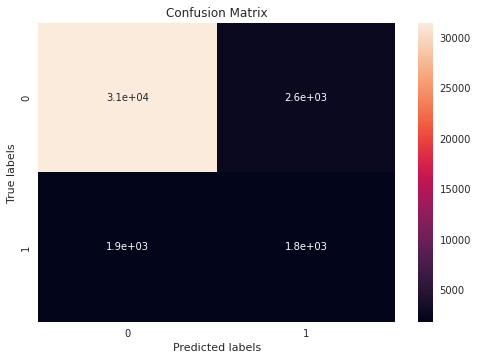

In [83]:
labels = ['0', '1']
cm = confusion_matrix(y_test, stacked_clf.predict(X_test_PCA))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) ;
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);
    

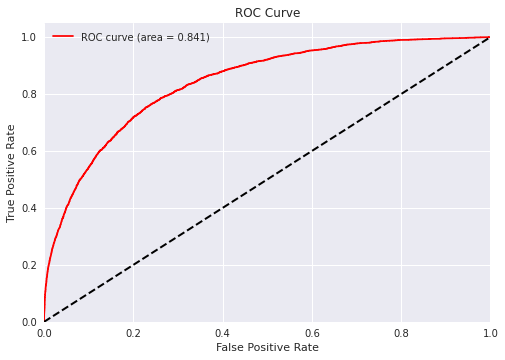

In [84]:
fpr, tpr, _ = roc_curve(y_test, stacked_clf.predict_proba(X_test_PCA)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="upper left")
plt.show()


## **Conclusion:**

> **All models are performing almost the same.** 

> **I tried to do a PCA to deal with overfiitting but that did not help the cause.**

> **Tried a stacked model, so as to get a better test score but that was also nearly same.**